In [1]:
%matplotlib inline

In [2]:
import time
debut = time.time()

# DCGAN Tutorial

Ce tutoriel a pour but de voir comment un réseau d'opposition génératif (GAN) peut générer de nouveaux visages après avoir vu de nombreuses photos de visages réelles.

Il est très très fortement inspiré du tutoriel de pytorch : [dcgan_faces_tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

## Generative Adversarial Networks

### Qu'est-ce qu'un GAN ?

Les GANs sont un modèle d'enseignement d'un modèle DL pour capturer la distribution des données d'entraînement afin de pouvoir générer de nouvelles données à partir de cette même distribution. Les GAN ont été inventés par Ian Goodfellow en 2014 et décrits pour la première fois dans le document [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). Ils sont constitués de deux modèles distincts, un **générateur** et un **discriminateur**:

- Le générateur produit de fausses images qui ressemblent aux images d'entraînement.
- Le discriminateur regarde une image et d'affiche s'il s'agit ou non d'une vraie image d'entraînement ou d'une fausse image provenant du générateur.

Pendant l'entraînement, le générateur essaie constamment de surpasser le discriminateur en générant de meilleurs faux, tandis que le discriminateur s'efforce de devenir un meilleur détective et de classer correctement les images réelles et fausses. L'équilibre de ce jeu est lorsque le générateur génère des faux parfaits qui semblent provenir directement des données d'entraînement, et que le discriminateur doit toujours deviner à 50% que la sortie du générateur est réelle ou fausse.

<img src="https://www.kdnuggets.com/wp-content/uploads/generative-adversarial-network.png" width="900"/>


Quelques notations :

- Pour le discriminateur :
    - **$x$**  : les données représentant une image.
    - **$D(x)$ : le réseau de discriminateurs** qui fournit la probabilité (scalaire) que $x$ provient des données d'entraînement plutôt que du générateur. L'entrée à $D(x)$ est une image RGB de taille 3x64x64. $D(x)$ devrait être ÉLEVÉ lorsque $x$ provient des vrai données et BAS lorsque $x$ provient du générateur. $D(x)$ peut aussi être considéré comme un classificateur binaire.

- Pour le générateur :
    - **$z$** : un vecteur d'espace latent échantillonné à partir d'une distribution normale standard.
    - **$G(z)$ : la fonction générateur** qui mappe le vecteur latent $z$ à l'espace de données. L'objectif de $G$ est d'estimer la distribution d'où proviennent les données d'entraînement ($p_{data}$) pour pouvoir générer de faux échantillons à partir de cette distribution estimée ($p_g$).

**$D(G(z))$ est la probabilité (scalaire) que la sortie du générateur $G$ soit une image réelle**.

Comme décrit dans [l'article de Goodfellow](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), $D$ et $G$ jouent à un jeu minimax :
- **$D$** tente de **maximiser** la probabilité qu'il classifie correctement les réels et les faux ($logD(x)$)
- **$G$** tente de **minimiser** la probabilité que $D$ prévoie que ses résultats soient faux ($log(1-D(G(x))$)). 

A partir du papier, la fonction de perte GAN est la suivante :

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

En théorie, **la solution à ce jeu minimax est où $p_g = p_{data}$**, et le discriminateur devine au hasard si les entrées sont réelles ou fausses.

Cependant, la théorie de la convergence des GANs fait encore l'objet de recherches actives et, en réalité, les modèles ne s'entraînent pas toujours à ce point.


### Qu'est-ce qu'un DCGAN?

Un DCGAN est une extension directe du GAN, sauf qu'il utilise explicitement des couches convolutives et convolutives-transpositives dans le discriminateur et le générateur, respectivement. Elle a été décrite pour la première fois par Radford et al. dans le document [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).

- Le discriminateur est composé de couches strided [convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d), de couches [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) et de couches d'activations [LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU). L'entrée est une image d'entrée 3x64x64 et la sortie est une probabilité scalaire que l'entrée provient de la distribution réelle des données.

- Le générateur est composé de couches [convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d), de couches [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) et d'activations [ReLU](https://pytorch.org/docs/stable/nn.html#relu). L'entrée est un vecteur latent, $z$, qui est tiré d'une distribution normale standard et la sortie est une image RGB 3x64x64. Les couches conv-transposées en strided permettent de transformer le vecteur latent en un volume ayant la même forme qu'une image.

Dans cet article, les auteurs donnent également quelques conseils sur la façon de configurer les optimiseurs, de calculer les fonctions de perte et d'initialiser les poids du modèle.

In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt


# Set random seed for reproducibility
import random
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs

Définissons quelques entrées pour le run :

In [4]:
dataroot = 'images/CFD_Images' # Répertoire racine pour l'ensemble de données

batch_size = 3**2  # Taille des lot pendant l'entraînement
image_size = 64 # Taille spatiale des images d'entraînement.
                #     Toutes les images seront redimensionnées comme suit en utilisant un transformateur.
                #     Cette implémentation par défaut est 64x64.
                #     Si une autre taille est souhaitée,  les structures de D et G doivent être modifiées.
                #     Voir [ici](https://github.com/pytorch/examples/issues/70)

nc = 3   # Nombre de canaux dans les images d'entraînement. (3 pour les images en couleur)
nz = 100 # Taille du vecteur latent z (c.-à-d. taille de l'entrée du générateur)
ngf = 64 # Taille des cartes d'entités dans le générateur
ndf = 64 # Taille des cartes d'entités dans le discriminateur

num_epochs = 15  # Nombre d'époques d'entraînement à exécuter.
                 # Un entraînement plus longtemps conduira probablement à de meilleurs résultats,
                 # mais prendra aussi beaucoup plus de temps


ngpu = 1        # Nombre de GPU disponibles. Utilisez 0 pour le mode CPU.

## Data

Dans ce tutoriel, nous utiliserons le jeu de données [Chicago Face Database](https://chicagofaces.org/default/). le dossier *CFD_Images* devra être placé dans dossier *images* :

    /images/CFD_Images
       -> AF-200
           -> CFD-AF-200-228-N.jpg
       -> AF-201
           -> CFD-AF-201-060-N.jpg
          ...

ImageFolder sera utilisé pour créer l'ensemble des données, il nécessite qu'il y ait des sous-répertoires dans le dossier racine (ces sous-repertoires sont utilisé pour créer les classes des données, que nous n'utiliseront pas ici).

In [5]:
# Nous pouvons utiliser un ensemble de données de dossier d'image de la façon dont nous l'avons configuré.

# Transformation à faire sur les image d'entraînement
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.Resize(image_size), # Resize the input PIL Image to the given size.
                              transforms.CenterCrop(image_size), # Crops the given PIL Image at the center.
                              transforms.ToTensor(), # Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
                              transforms.Normalize(mean=(0.5, 0.5, 0.5), # Normalize a tensor image with mean and standard deviation.
                                                   std=(0.5, 0.5, 0.5)) 
                             ]) 



# Créez l'ensemble de données
import torchvision.datasets as dset
dataset = dset.ImageFolder(root=dataroot, transform=transform)

# Créez le dataloader -- permet d'utiliser le dataset avec torch
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Décidez sur quel appareil nous voulons tourner
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#device = torch.device("cpu")
device

device(type='cuda', index=0)

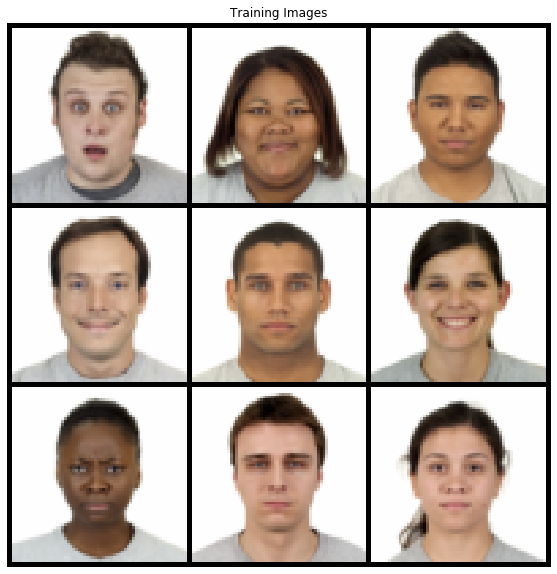

In [6]:
# Afficher des images d'entraînement

real_batch = next(iter(dataloader))
# real_batch[0] -> images d'un lot d'entrainement
# real_batch[1] -> classes des images d'un lot d'entraînement


import torchvision.utils as vutils
# on fabrique une grille des images
grid_images = vutils.make_grid(real_batch[0].to(device), padding=2, nrow=int(batch_size**.5), normalize=True).cpu()
images = np.transpose(grid_images, (1,2,0)) # permet de réarranger grid_images pour pouvoir l'afficher


plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(images);

## Implementation

### Initialisation du poids


D'après l'article du DCGAN, les auteurs précisent que tous **les poids du modèle doivent être initialisés** de façon aléatoire à partir d'une **distribution normale (mean=0 et stdev=0,02)**.

La fonction ``weights_init`` prend un modèle initialisé en entrée et réinitialise toutes les couches de normalisation convolutive, convolutive-transposition et batch pour répondre à ce critère. Cette fonction est appliquée aux modèles immédiatement après l'initialisation.

In [7]:
# Fonction d'initialisation de poids personnalisés appelés sur les réseaux générateur et discriminateur
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generateur

Le générateur, $G$, est conçu pour mapper le vecteur d'espace latent ($z$) dans l'espace de données.

Puisque nos données sont des images, convertir $z$ en espace de données signifie créer une image RGB de la même taille que les images d'entraînement (ici 3x64x64). Cela se fait par une série de couches convolutionnelles bidimensionnelles transposées (**ConvTranspose2d**), chacune couplée à une couche de **BatchNorm2d** et à une activation **ReLu**. La sortie du générateur est alimentée par une fonction **Tanh** pour revenir à la plage de données d'entrée de $[-1,1]$. Les fonctions de BatchNorm2d se situent après les couches ConvTranspose2d, c'est une contribution essentielle du document DCGAN. Ces couches aident à l'écoulement des gradients pendant l'entraînement.

Une image du générateur tirée de l'article de DCGAN est montrée ci-dessous.

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="900"/>

Les entrées définient dans la section d'entrée (*nz*, *ngf*, et *nc*) influencent l'architecture du générateur :
- **nz** est la longueur du vecteur d'entrée z,
- **ngf** se rapporte à la taille des cartes de caractéristiques qui sont propagées par le générateur,
- **nc** est le nombre de canaux dans l'image de sortie (défini à 3 pour les images RGB).

In [8]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # entrée est Z, entrant dans une convolution
            nn.ConvTranspose2d(nz, ngf*8, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # taille des états (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # taille des états (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # taille des états (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d(ngf*2, ngf, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # taille des états(ngf) x 32 x 32
            
            nn.ConvTranspose2d(ngf, nc, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # taille des états (nc) x 64 x 64
        
        )

    def forward(self, input):
        return self.main(input)

### Discriminator

Le discriminateur $D$ est un réseau de classification binaire qui prend une image en entrée et émet une probabilité scalaire que l'image entrée est réelle (par opposition à fausse).

Ici, $D$ prend une image d'entrée 3x64x64, la traite à travers une série de couches **Conv2d**, **BatchNorm2d**, et **LeakyReLU**, et affiche la probabilité finale par une fonction d'activation Sigmoid.

Cette architecture peut être étendue avec d'autres couches, mais l'utilisation de la convolution stridée (ici stride = 2 ou 1), BatchNorm et LeakyReLU est importante. Le document du DCGAN mentionne que c'est une bonne pratique d'utiliser la convolution stridée plutôt qu'un pooling pour réduire l'échantillon parce qu'elle permet au réseau d'apprendre sa propre fonction de pooling. De plus, les fonctions BatchNorm et LeakyReLU favorisent un flux de gradient équilibré, ce qui est essentiel pour le processus d'apprentissage des $G$ et des $D$.

<img src="https://sigmoidal.io/wp-content/uploads/2017/09/deep_convolutional_generative_adversarial_network1.png" width="1000"/>


In [9]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # entrée est (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf) x 32 x 32
            
            nn.Conv2d(ndf, ndf*2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf*2, ndf*4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf*4, ndf*8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # taille des états (ndf*8) x 4 x 4
            
            nn.Conv2d(ndf*8, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Maintenant, nous pouvons instancier le générateur et le discriminateur et appliquer la fonction ``weights_init``. Vérifiez le modèle retourné pour voir comment les objets générateur et discriminateur sont structuré.

In [10]:
# Créez le générateur
netG = Generator(ngpu).to(device)

# Créer le discriminateur
netD = Discriminator(ngpu).to(device)


# Manipulez le multi-gpu si vous le souhaitez
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Appliquer la fonction weights_init pour initialiser aléatoirement tous les poids pour mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

# Afficher les modèles
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Les fonctions de perte et les optimiseurs

Avec la configuration $D$ et $G$, nous pouvons spécifier comment ils apprennent à travers les fonctions de perte et les optimiseurs.

- La fonction de perte d'entropie binaire [BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss) sera utilisé. Elle est définie dans PyTorch comme :
    \begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}
    Cette fonction fournit le calcul des deux composantes log dans la fonction objectif ($log(D(x))$ et $log(1-D(G(z)))$).
    
    La partie de l'équation de BCE à utiliser peut être spécifié en changeant simplement $y$ (les étiquettes) :
    - $l_n = - [\log x_n]$ pour $y=1$
    - $l_n = - [\log (1 - x_n)]$ pour $y=0$

- L'étiquette réelle sera définit comme 1 et la fausse étiquette comme 0. Elles seront utilisées pour calculer les pertes de $D$ et $G$.

- Deux optimiseurs distincts seroont mis en place, l'un pour $D$ et l'autre pour $G$. Les deux sont des optimiseurs d'Adam avec un taux d'apprentissage (lr) de 0,0002 et Beta1 = 0,5 (voir le document du DCGAN).

Pour suivre la progression d'apprentissage du générateur, nous allons générer un lot fixe de vecteurs latents qui sont tirés d'une distribution gaussienne (fixed_noise). Dans la boucle d'apprentissage, nous entrerons périodiquement ce bruit_fixe dans $G$, et au cours des itérations, nous verrons des images se former à partir du bruit.

In [11]:
# Initialiser la fonction BCELoss
criterion = nn.BCELoss()

# Créer un lot de vecteurs latents que nous utiliserons pour visualiser la progression du générateur
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Établir une convention pour les vraies et fausses étiquettes pendant la formation
real_label = 1
fake_label = 0

# Configurez les optimiseurs Adam pour G et D
import torch.optim as optim

lr = 0.0002     # Taux d'apprentissage des optimiseurs
beta1 = 0.5     # Beta1 hyperparamètre pour les optimiseurs Adam

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training


L'entraînement au GAN est délicat, des paramètres hyperparamétriques incorrects entraînent l'effondrement du mode sans que l'on sache vraiment ce qui s'est mal passé.

Ici, nous suivrons l'algorithme 1 de l'article de Goodfellow, tout en respectant certaines des meilleures pratiques présentées dans [ganhacks](https://github.com/soumith/ganhacks). A savoir, nous allons "construire différents mini-lots pour des images réelles et fausses", et aussi ajuster la fonction objectif de G pour maximiser $log(D(G(z)))$.

L'entraînement est divisée en deux parties principales. La partie 1 met à jour le Discriminateur et la partie 2 met à jour le Generateur.

- **Part 1 - Entraînement Discriminateur**

    L'objectif de cet entraînement est de maximiser la probabilité de classer correctement un intrant donné comme réel ou faux. En ce qui concerne Goodfellow, nous souhaitons "mettre à jour le discriminateur en augmentant son gradient stochastique". Concrètement, nous voulons **maximiser $log(D(x)) + log(1-D(G(z)))$**. En raison de la suggestion de mini-lots séparée de ganhacks, nous allons calculer cela en deux étapes :
    1. Entraînement avec des lots d'**images réels** :
        1. Construire un lot d'échantillons réels
        2. Passer par $D$
        3. Calculer la perte ($log(D(x))$)
        4. Calculer les gradients dans une passe en arrière.
    2. Entraînement avec des lots de **fauses images** :
        1. Construire un lot de faux échantillons avec le générateur actuel
        2. Passer ce lot par $D$
        3. Calculer la perte ($log(1-D(G(z)))$)
        4. *Accumuler* les gradients avec une passe en arrière.
    3. Mise à jour des paramètres de D avec une étape d'optimisation.

Maintenant, avec les gradients accumulés à partir des lots tout réel et tout faux, nous appelons une étape de l'optimiseur du Discriminator.

- **Part 2 - Entraînement Generateur**

    Nous voulons entraîner le Générateur en **minimisant $log(1-D(G(z)))$** pour générer de meilleurs faux. Goodfellow a montré que cela ne permettait pas d'obtenir des gradients suffisants, surtout au début du processus d'apprentissage. En guise de correctif, nous souhaitons plutôt **maximiser $log(D(G(z)))$**.

    Pour classifier la sortie du Générateur de la Partie 1 avec le Discriminator, nous passerons par plusieur étapes :
    1. Calcule de la perte de G en utilisant des **étiquettes réelles** ($log(D(G(z)))$)
    2. Calcule des gradients de G dans une passe en arrière
    3. Mise à jour des paramètres de G avec une étape d'optimisation.

    On utilise les étiquettes réelles pour la fonction de perte, pour utiliser la partie $log(x)$ du BCELoss (plutôt que la partie $log(1-x)$)

À la fin de chaque époque, nous pousserons notre lot de bruit fixe (fixed_noise) à travers le générateur pour suivre visuellement la progression de la formation de G.

Les statistiques de formation rapportées sont :

- **Loss_D** - perte du discriminateur $log(D(x)) + log(1-D(G(z)))$ - somme des pertes pour tous les lots réels et tous les faux lots.
-  **Loss_G** - perte du générateur $log(D(G(z)))$.
- **D(x)** - sortie moyenne du discriminateur pour le lot réel. Elle devrait commencer près de 1 puis converger vers 0,5 lorsque G s'améliore.
- **D(G(z))** - sortie moyenne du discriminateur pour le lot faux. Le premier chiffre est avant que D ne soit mis à jour et le deuxième chiffre est après que D soit mis à jour. Ils devraient commencer près de 0 puis converger vers 0,5 lorsque G s'améliore.

**Remarque:** Cette étape peut prendre un certain temps, selon le nombre d'époques que vous exécutez.

In [12]:
# Boucle d'entraînement

# Listes pour suivre l'avancement des projets
img_list = []
G_losses = []
D_losses = []

D_x_score = []
D_G_z1_score = []
D_G_z2_score = []

iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs): # Pour chaque époque
    
    for i, data in enumerate(dataloader, 0): # Pour chaque lot dans le dataloader
        
        #====================================================================================================
        
        ########################################################################
        # 1 - Mise à jour du réseau D : maximiser log(D(x)) + log(1 - D(G(z))) #
        ########################################################################
        
        netD.zero_grad() # Règle les gradients de tous les paramètres du modèle à zéro. (Backpropagation 1)
        
        #-----------------------------------------------------------------------
        
        # Entraînement avec des lots d'images réels
        #------------------------------------------
        real_img = data[0].to(device) # x - Lot d'images réels
        b_size = real_img.size(0) # nombre d'images dans le lot
        
        label = torch.full((b_size,), real_label, device=device) # real_label pour chaque images du lot réel
        output = netD(real_img).view(-1) # D(x) - Classe le lot réel avec D
        errD_real = criterion(output, label) # log(D(x)) - calcule la perte de D sur le lot réel
        errD_real.backward()  # Calcule les gradients pour D en pas en arrière. (Backpropagation 2)
        D_x = output.mean().item()
        
        # Entraînement avec des lots de fauses images
        #--------------------------------------------
        noise = torch.randn(b_size, nz, 1, 1, device=device) # z - Lot de vecteurs latents
        fake = netG(noise) # G(z) - Crée un lot de fausses images avec G
        
        label.fill_(fake_label) # fake_label pour chaque images du lot faux
        output = netD(fake.detach()).view(-1) # D(G(z)) - Classe le lot faux avec D
        errD_fake = criterion(output, label) # log(1-D(G(z))) - calcule la perte de D sur le lot faux
        errD_fake.backward() # Calcule les gradients pour D en pas en arrière. (Backpropagation 2)
        D_G_z1 = output.mean().item()
        
        #-----------------------------------------------------------------------
        
        errD = errD_real + errD_fake # log(D(x)) + log(1-D(G(z))) - somme des gradients des lots réel et faux.
        optimizerD.step() # Mise à jour D (Backpropagation 3)
        
        ########################################################################
        # 2 - Mise à jour du réseau G : maximiser log(D(G(z)))                 #
        ########################################################################
        
        netG.zero_grad() # Règle les gradients de tous les paramètres du modèle à zéro. (Backpropagation 1)
        
        #-----------------------------------------------------------------------
        
        # Entraînement avec des labels réels 
        #-----------------------------------
        label.fill_(real_label) # real_label pour chaque images du lot faux (pour log(D(G(z)))
        output = netD(fake).view(-1) # D(G(z)) - Classe le lot faux avec D (avec D déjà mis à jour)
        errG = criterion(output, label) # log(D(G(z))) - calcule la perte de G à partir de ce résultat.
        errG.backward() # Calcule les gradients pour G en pas en arrière. (Backpropagation 2)
        D_G_z2 = output.mean().item()
        
        #-----------------------------------------------------------------------
        
        optimizerG.step() # Mise à jour G (Backpropagation 3)
        
        #====================================================================================================
        
        
        # Statistiques d'entraînement
        if i % (len(dataloader)-1) == 0:
            print('[%d/%d][%d/%d]    \tLoss_D: %.3f\tLoss_G: %.3f\t\tD(x): %.3f\tD(G(z)): %.3f / %.3f'
                  % (epoch+1, num_epochs, i+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Enregistrement :
        # - pertes
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # - scores
        D_x_score.append(D_x)
        D_G_z1_score.append(D_G_z1)
        D_G_z2_score.append(D_G_z2)
        
        
        # Sauvegarde de la sortie de G sur le bruit_fixe.
        if (iters % len(dataloader) == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, nrow=int(batch_size**.5), normalize=True))
            
        iters += 1

Starting Training Loop...
[1/15][1/135]    	Loss_D: 1.502	Loss_G: 8.173		D(x): 0.667	D(G(z)): 0.571 / 0.001
[1/15][135/135]    	Loss_D: 0.000	Loss_G: 36.412		D(x): 1.000	D(G(z)): 0.000 / 0.000
[2/15][1/135]    	Loss_D: 0.000	Loss_G: 36.138		D(x): 1.000	D(G(z)): 0.000 / 0.000
[2/15][135/135]    	Loss_D: 0.000	Loss_G: 37.247		D(x): 1.000	D(G(z)): 0.000 / 0.000
[3/15][1/135]    	Loss_D: 0.000	Loss_G: 35.957		D(x): 1.000	D(G(z)): 0.000 / 0.000
[3/15][135/135]    	Loss_D: 0.183	Loss_G: 5.634		D(x): 0.925	D(G(z)): 0.100 / 0.004
[4/15][1/135]    	Loss_D: 0.114	Loss_G: 5.809		D(x): 0.922	D(G(z)): 0.019 / 0.023
[4/15][135/135]    	Loss_D: 5.410	Loss_G: 1.276		D(x): 0.005	D(G(z)): 0.132 / 0.279
[5/15][1/135]    	Loss_D: 2.669	Loss_G: 11.232		D(x): 0.967	D(G(z)): 0.849 / 0.000
[5/15][135/135]    	Loss_D: 1.286	Loss_G: 0.019		D(x): 0.302	D(G(z)): 0.086 / 0.982
[6/15][1/135]    	Loss_D: 2.967	Loss_G: 5.329		D(x): 0.999	D(G(z)): 0.898 / 0.023
[6/15][135/135]    	Loss_D: 1.529	Loss_G: 0.025		D(x): 0.

## Résultats

### Loss versus training iteration

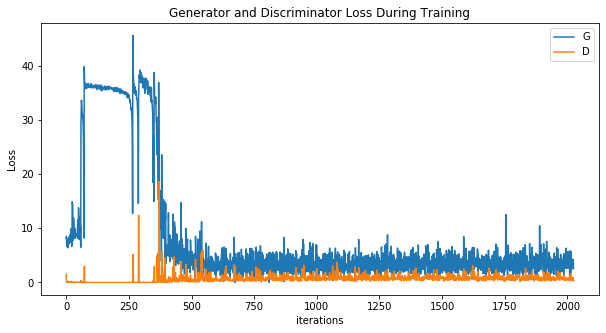

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Score versus training iteration

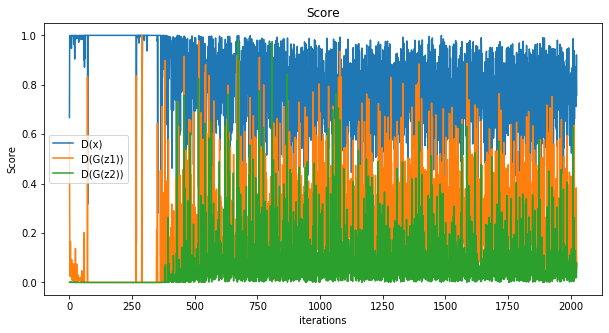

In [14]:
plt.figure(figsize=(10,5))
plt.title("Score")

plt.plot(D_x_score,label="D(x)")
plt.plot(D_G_z1_score,label="D(G(z1))")
plt.plot(D_G_z2_score,label="D(G(z2))")
plt.xlabel("iterations")
plt.ylabel("Score")
plt.legend()
plt.show()

### Visualization of G’s progression

Rappelez-vous comment nous avons sauvegardé la sortie du générateur sur le lot de bruit fixe après chaque époque de formation. Maintenant, nous pouvons visualiser la progression de l'entraînement de G avec une animation. Appuyez sur le bouton de lecture pour démarrer l'animation.

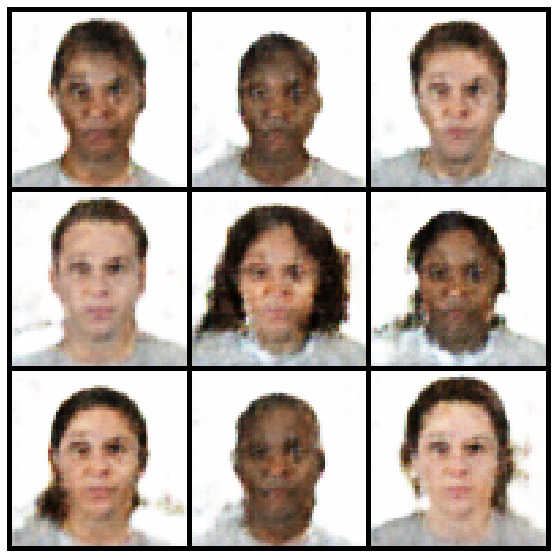

In [15]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Real Images vs. Fake Images

Enfin, jetons un coup d'oeil à de vraies images et à de fausses images côte à côte.

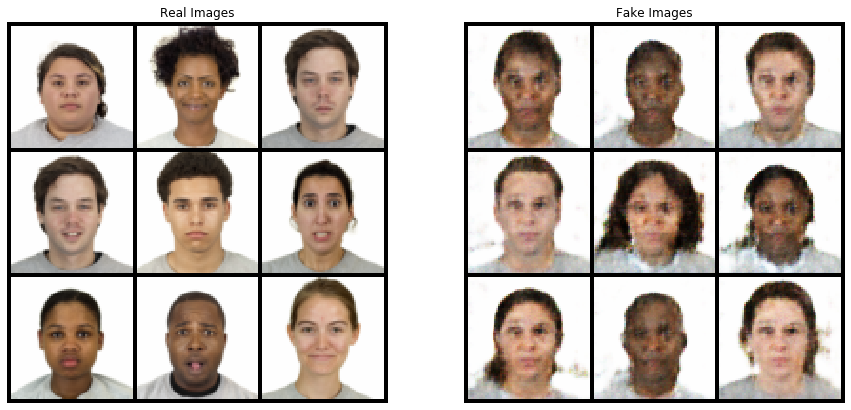

In [16]:
# Récupérer un lot d'images réelles du dataloader
real_batch = next(iter(dataloader))

# Tracez les images réelles
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), nrow=int(batch_size**.5), padding=2, normalize=True).cpu(),(1,2,0)))
#plt.show()

# Tracez les fausses images de la dernière époque
#plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
fin = time.time()
print((fin-debut)//60, 'min')

9.0 min


# Oú aller ensuite


Nous sommes arrivés à la fin de notre voyage, mais il y a plusieurs endroits où vous pouvez aller à partir d'ici. Vous pourriez :

- S'entraîner plus longtemps pour voir à quel point les résultats sont bons
- Modifier ce modèle pour prendre un ensemble de données différent et éventuellement modifier la taille des images et l'architecture du modèle.
- Jetez un coup d'œil à d'autres projets GAN sympas [ici](https://github.com/nashory/gans-awesome-applications)
- Créer des GANs qui génèrent de la [musique](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)